# IQ Mixing notes

https://markimicrowave.com/technical-resources/application-notes/how-to-think-about-iq-mixers/

In [1]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.insert(1, '..\\Instruments\\network\\RS_Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\HDF5')

import RS_SMA100B
import FSL_0010
from Card_Class import PXIe5170R
from HDF5 import save_dict_to_hdf5 as hdf5_write

In [10]:
QSyn_port       = 'COM35'
SG_ip           = '192.168.40.15'                                   # Set IP address of the device
Card_Name       = 'PXI1Slot3'

fsl             = FSL_0010.FSL10_synthesizer(device_address = QSyn_port)
sGen            = RS_SMA100B.SMA100B(ip = SG_ip)
pxie            = PXIe5170R(resource_name = Card_Name)

FSL_0010:	Connection successful!
SMA100B:	Connection successful!
PXIe_5170R:    Connection successful!


In [11]:
pulse_f_min     = 1.010e9
# pulse_f_max		= 

amp_min		    = -18                                               # Set the amplitude of the signal in dBm
# amp_max			= 


sample_rate     = 250e6                                             # Maximum Value: 250.0e6
k = 4                                                               # coefficiente per prendere k*1000 punti 
																	# con la scheda, dunque devo aumentare la pulse width e period
pulse_period    = k * 1e-6                                          # 4e-6 con 250e6 dà 1000 punti
num_pts         = int(sample_rate * pulse_period)                   # min 5ns                             
pulse_delay     = 0

percent         = 5
pulse_width     = pulse_period * (1 - percent/100)                  # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = num_pts
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6


# FSL-0010
fsl.set_frequency(1) # GHz

'FSL_0010: Frequency set to 1 GHz.'

In [12]:
trig_CH = 0
I_CH	= 2
Q_CH	= 3

print(fsl.set_output('ON'))
pxie.open(trigger_channel = str(trig_CH))

pota        = np.arange(amp_min, amp_min + 10 , 1)
pula        = np.arange(pulse_f_min, pulse_f_min + 0.010e9, 0.001e9)

data_dict   = {}
counter     = 1


digits_p = "{:0"+str(len(str(len(pota))))+"d}"
digits_f = "{:0"+str(len(str(len(pula))))+"d}"
for p, pot in enumerate(pota):
	data_dict[f'p{digits_p.format(p)}'] = {'power_(dBm)': pot, 'freqs': {}}
	sGen.RF_lvl_ampl(pot)

	for i, pul in enumerate(pula):
		
		sGen.RF_freq(pul) # guarda come è definito, abbiamo messo la potenza e6   
		sGen.pul_state(1)
		sGen.RF_state(1)
		# time.sleep(0.1)
		waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
		I = np.array(waveforms[I_CH].samples.tolist())
		Q = np.array(waveforms[Q_CH].samples.tolist())
		# if p == 0 and i == 0:

		# 	cln_pts = 30                # clean points for I-Q plane
		# 	plt.clf()
		# 	plt.scatter(Q[cln_pts:-cln_pts],I[cln_pts:-cln_pts])
		# 	plt.show()
		
		
		sGen.pul_state(0)
		sGen.RF_state(0)

		print(f'\r(p{digits_p.format(p)}, f{digits_f.format(i)})	: {int(counter*100/(len(pota)*len(pula)))} %', end='')
		sys.stdout.flush()
		counter += 1
		data_dict[f'p{digits_p.format(p)}']['freqs'][f'f{digits_f.format(i)}'] = {'freq_(Hz)': pul, 'I': I, 'Q': Q}
print(fsl.set_output('OFF'))




RF set to ON
(p09, f09)	: 100 %

'RF set to OFF'

In [13]:
# SAVE DATA ON HDF5 FILE
filename = 'Tappo_su_I_cambiocavo_e_canale-ciccio.h5'
if os.path.exists(filename):
  os.remove(filename)
hdf5_write(data_dict, filename)

In [14]:
fsl.close()
pxie.close()

FSL_0010:	Connection closed.
PXIe_5170R: Session closed


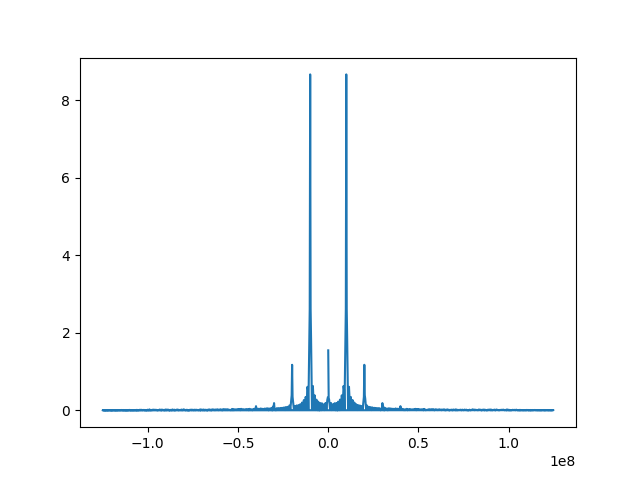

In [ ]:
# def weight_factor (ft, range_mask):
# 	# tot_int = np.trapz(ft)
# 	tot_int = np.sum(ft)
# 	ft[~range_mask] = 0
# 	# portion = np.trapz(ft)
# 	portion = np.sum(ft)

# 	return tot_int/portion

# def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
# 	N = len(y)
# 	T = 1/sample_rate
# 	FT = np.fft.fft(y)
# 	PHI = np.unwrap(np.angle(FT))

# 	x = np.arange(len(y))/sample_rate
# 	freqs = np.fft.fftfreq(N,T) 
# 	offset = 5e6

# 	if toggle_plot:
# 		plt.clf()
		
	   
# 		plt.plot(freqs,np.abs(FT))
# 		plt.show()
	
# data_fft(a, 80e6, sample_rate, True)

## NOTE
- [ ] Dai test sembra che non servano attenuazioni quando il segnale passa per il mixer, ma è necessaerio capire quanta potenza effettivamente arriva alla scheda per non friggerla.
- [ ] DOVREMO fare la CARATTERIZZAZIONE DELL'IQ-MIXER
- [ ] Studiare range di ampiezze in cui opera e magari anhe range di frequenze.
- [ ] Studiare Attenuazione che dà?
- [ ] Nel piano I-q non compare una circonferenza precisa, ma è più un'ellisse. Studiare e magari richiedere.
- [ ] Preparare i programmi, anche per l'analisi dati in loco per risparmiare tempo.
- [ ] Scrivere una manuale per la pixie, in particolare per l'uso del trigger esterno.